In [1]:
DATASET = 'full'
OUTNAME = 'SAGE'

In [2]:
import sys
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
import gc
from sklearn.manifold import TSNE
import seaborn as sns
from cluster_utils import evaluate_items
from vis_utils import (visualize_students, visualize_edges_age, visualize_edges, visualize_items, myresults, FIGSIZE,
CLUSTER_LABELS,  AGE_THR, DPI, CPU_Unpickler, plot_clustering)

sns.set_theme(context='talk', style='white')

FILENAME = f'{OUTNAME}_{DATASET}'
EQUAL_AXES=False
MINSAMPLES = 10
RELOAD = False
NPERMS = 100

In [3]:
torch.cuda.empty_cache()
device = 'cpu'
model = torch.load(f'./results/{FILENAME}.pth.tar', map_location=torch.device('cpu'))

In [4]:
with open(f'./results/{FILENAME}_aux_data.pkl', 'rb') as handle:
    aux_data = CPU_Unpickler(handle).load()
    
(df, df_student, df_item, df_edge, 
            train_losses, #test_losses, test_aucs,
            train_edge_indices, val_edge_indices, test_edge_indices, 
            data, train_data, val_data, test_data,
            unique_scales, unique_domains, unique_matdiff, 
            DATA_FILE) = aux_data
print(df_item.shape)

try:
    # if IRT data exists, take item parameters
    with open(f'./results/IRT_{DATASET}_aux_data_IRT1.pkl', 'rb') as handle:
        aux_data = CPU_Unpickler(handle).load()

    (_, _, df_item, *_) = aux_data
except:
    pass
print(df_item.shape)

(35087, 8)
(35087, 10)


In [5]:
df_item

,scale,matrix,IRT_difficulty,matdiff,topic,responseformat,textlength,domain,IRT1_difficulty,IRT1_discrimination
0,fhoe,F.1.A.1.c.1,-0.370330,,Monologe und Dialoge,NaN,NaN,f,4.493976,1.282696
1,fhoe,F.1.A.1.c.1,-0.370330,,Monologe und Dialoge,NaN,NaN,f,4.499678,-1.175209
2,fhoe,F.1.A.1.c.1,-0.370330,,Monologe und Dialoge,NaN,NaN,f,4.619348,0.037622
3,fhoe,F.1.A.1.c.1,-0.370330,,Monologe und Dialoge,NaN,NaN,f,3.899144,-0.535258
4,fles,F.2.A.1.b.3,-0.494880,,Berichte,NaN,NaN,f,4.413169,-1.520244
...,...,...,...,...,...,...,...,...,...,...
11208104,esif,NaN,NaN,,NaN,NaN,NaN,e,3.850175,5.165676
11208105,esif,NaN,NaN,,NaN,NaN,NaN,e,4.738880,3.640941
11661701,mzuv,MA.1.A.2.c.1,-1.441187,,Anzahlen,open,NaN,m,2.738985,1.354192
12448337,eles,NaN,NaN,,NaN,NaN,NaN,e,3.084314,1.153537


In [6]:
if RELOAD:
    df = load_data_heterogeneous(DATA_FILE)
    data, df_student, df_item, df_edge = create_data_object_heterogeneous(df)

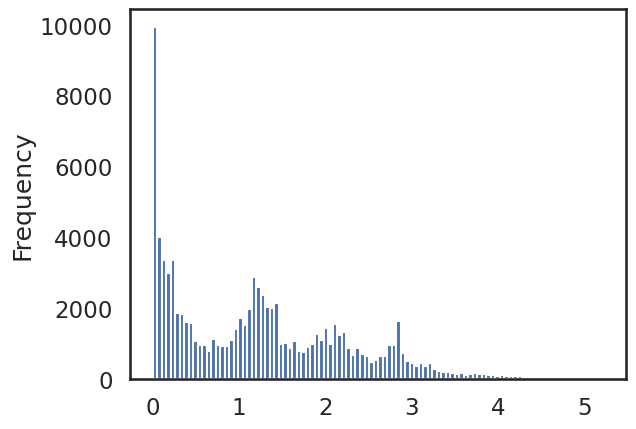

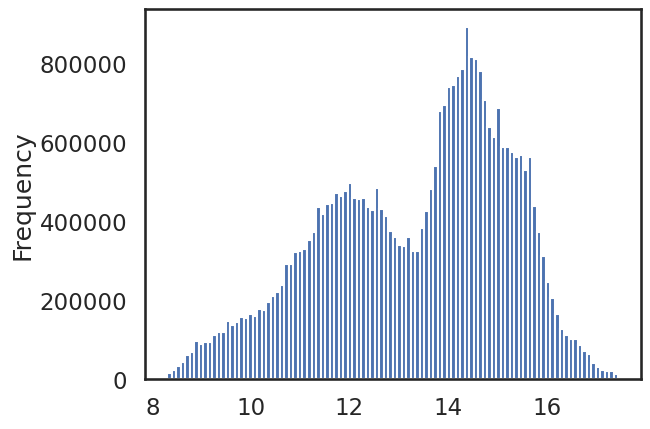

In [7]:
%matplotlib inline
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())
fig = plt.figure()
age_ranges.plot.hist(bins=100)
plt.show()

fig = plt.figure()
df.age.plot.hist(bins=100)
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())

plt.show()

236.0

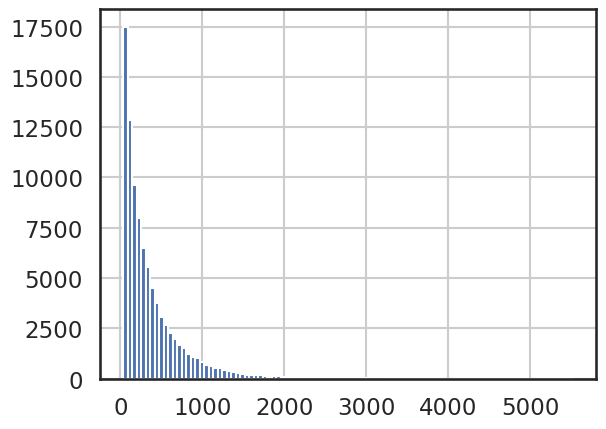

In [8]:
# different items per student
df.groupby(['studentId']).code.nunique().hist(bins=100)
df.groupby(['studentId']).code.nunique().median()

10.0

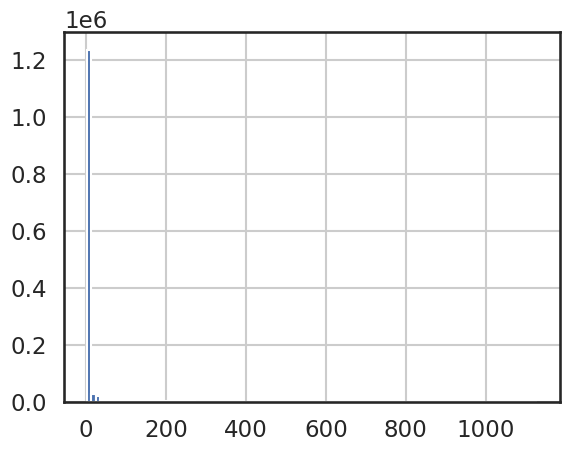

In [9]:
df.groupby(['assessmentId']).code.nunique().hist(bins=100)
df.groupby(['assessmentId']).code.nunique().median()

In [10]:
age_ranges.mean()

1.2189035417825627

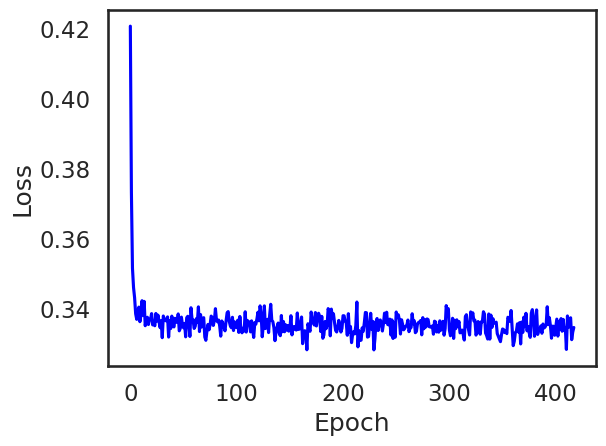

In [11]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()
plt.savefig(f'./vis/{FILENAME}_losses.png', dpi=DPI)

In [12]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,timestamp,useCase,assessmentId,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,7.830814e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
1,0,1,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,7.830814e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
2,0,2,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,7.830814e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
3,0,3,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,7.830814e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
4,0,4,1.0,0.0,fles,F.2.A.1.b.3,-0.49488,Berichte,NaN,NaN,...,7.833807e-312,ms-thema-auto,0D59C4843FFC39195EDE1DD140506CF3DF8BC6F132AAF5...,0.657010,2.727266,3,1.10,,,f


In [13]:
#np.sum(df.ability.isnull() == False)

In [14]:
myresults.output_stats()

In [15]:
#print(domain_train)
#print(domain_train_rand)
#print(domain_val)

In [16]:
scores_dict = {'CH': [], 'SH': [], 'DB':[]}
distances_dict = {'within': [], 'between': []}

for perm in range(NPERMS):
    scores, within_domain, between_domain, mean_distances = evaluate_items(model, train_data, df_item, device, 
                                                                           shuffle=perm>0, 
                                                                           seed=0, 
                                                                           minsamples=MINSAMPLES)
    [ scores_dict[key].append(scores[key]) for key in scores_dict]
    distances_dict['within'].append(within_domain)
    distances_dict['between'].append(between_domain)

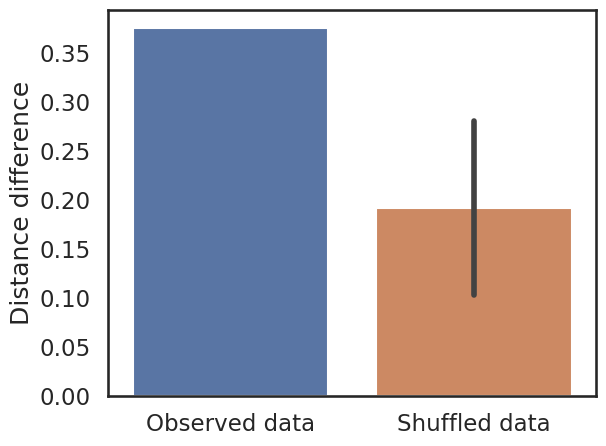

In [17]:
distances_df = pd.DataFrame(distances_dict)
distances_df['perm'] = distances_df.index
#distances_df = pd.melt(distances_df, id_vars='perm', value_name='index', var_name='group')
distances_df['random'] = 'Observed data'
distances_df.loc[ distances_df['perm'] > 0, 'random'] = 'Shuffled data'
distances_df['diff'] = distances_df['between'] - distances_df['within'] 
fig = plt.figure()
ax = sns.barplot(data=distances_df, x='random', y='diff', errorbar='sd')
ax.set(xlabel='', ylabel='Distance difference')
fig.tight_layout()

plt.savefig(f'./vis/{FILENAME}_bw.png', dpi=DPI)

In [18]:
#fig, axes = plt.subplots(1, 2, figsize=(16, 6))
from matplotlib.category import UnitData

for i, index in enumerate(['CH', 'DB']): #scores_dict
    fig = plt.figure(figsize=(FIGSIZE))
   
    scores_df = pd.DataFrame(scores_dict[index])
    scores_df['perm'] = scores_df.index
    scores_df = pd.melt(scores_df, id_vars='perm', value_name='index', var_name='scale')
    scores_df['random'] = 'Observed data'
    scores_df.loc[ scores_df['perm'] > 0, 'random'] = 'Shuffled data'
    #plt.figure()
    scores_df['scale'] = pd.Categorical(scores_df['scale'], categories=np.sort(scores_df.scale.unique()))
    axes = sns.barplot(data=scores_df, x='scale', y='index', hue='random', errorbar='sd')
    axes.legend_.remove()
    axes.set_xlabel('Competence Domain')
    axes.set_ylabel('Cluster Validity Index Value')
    axes.set_title(CLUSTER_LABELS[index])
    axes.tick_params(axis='x', rotation=90)
    fig.tight_layout()
    plt.savefig(f'./vis/{FILENAME}_bw_random_{index}.png', dpi=DPI)
    plt.close()

In [19]:
DIFFICULTY_BINS = 21
df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)

In [20]:
plot_clustering('scalexdifficulty', 'topic', model, val_data, df_item, device, FILENAME, minsamples=MINSAMPLES, nperms=NPERMS)
plot_clustering('scalexdifficulty', 'matrix', model, val_data, df_item, device, FILENAME, minsamples=MINSAMPLES, nperms=NPERMS)
if DATASET in ['matrix', 'topic']:
    sys.exit()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

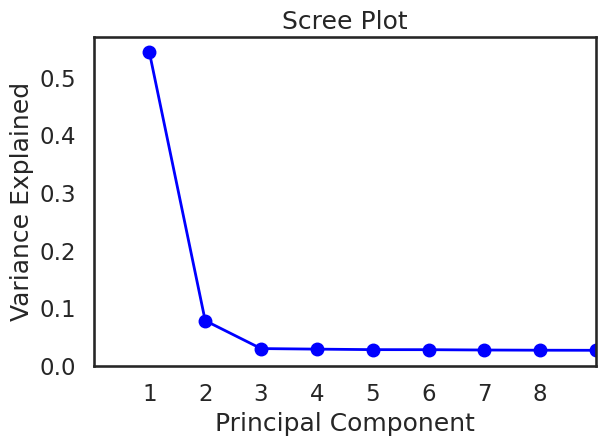

In [21]:
visualize_items(model, train_data, device, df_item, FILENAME, equal_axes=EQUAL_AXES)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

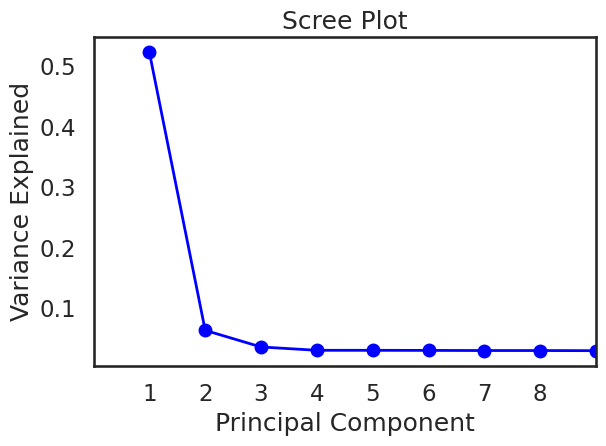

In [22]:
visualize_students(model, train_data, device, df_student, FILENAME, equal_axes=EQUAL_AXES)

In [23]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=True, aggregate=True, AGE_THR=AGE_THR)

In [24]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=False, aggregate=False, AGE_THR=AGE_THR)

%matplotlib inline 
EQUAL_AXES = False
ALPHA = 0.6
FIGSIZE2 = (12, 6)

visualize_edges_age(model, train_data, train_edge_indices, device, df, OUTNAME , equal_axes=EQUAL_AXES, 
                             age_window=(8, 11), aggregate=True, hue_label='motherTongue', with_lines=True, save=False)        

visualize_edges_age(model, train_data, train_edge_indices, device, df, OUTNAME, equal_axes=EQUAL_AXES, 
                             age_window=(8, 13), aggregate=True, hue_label='age', with_lines=True, save=False)        

visualize_edges_age(model, train_data, train_edge_indices, device, df, OUTNAME, equal_axes=EQUAL_AXES, 
                             age_window=(11, 18), aggregate=True, hue_label='age', with_lines=True, save=False)